# Utils

In [1]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

In [2]:
#export
from fastai import datasets
import torch
import gzip
import pickle
import matplotlib as mpl
import matplotlib.pyplot as plt
from torch import tensor
import random
import operator
import os

os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [3]:
#export
def process_mnist(xt, yt, xv, yv):
    '''Process mnist data with normalization.
        xt: x (input) training data
        yt: y (label) training data
        xv: x (input) validation data
        yv: y (label) validation data
    '''
    xt, yt, xv, yv = map(tensor, (xt, yt, xv, yv))
    xt, xv = xt.float(), xv.float()
    mean, std = xt.mean(), xt.std()
    xt, xv = normalize(xt, mean, std), normalize(xv, mean, std)
    return xt, yt, xv, yv

In [4]:
#export
mpl.rcParams['image.cmap'] = 'gray'

name2url = {'mnist': 'http://deeplearning.net/data/mnist/mnist.pkl'}
name2fn = {'mnist': process_mnist}

def get_mnist_data():
    '''Get mnist dataset.'''
    return get_data('mnist')
    
def get_data(name):
    '''Get dataset by name.
        name: dataset name
    '''
    if name not in name2url or name not in name2fn:
        raise Exception('Unrecognized dataset')
        
    path = datasets.download_data(name2url[name], ext='.gz')
    with gzip.open(path, 'rb') as f:
        ((xt, yt), (xv, yv), _) = pickle.load(f, encoding='latin-1')
    
    return name2fn[name](xt, yt, xv, yv)

def show_random_image(imgs):
    '''Show random image from a batch of images with matplotlib.
        imgs: container of images to randomly choose from
    '''
    img = random.choice(imgs)
    if len(img.shape) == 1:
        size = int(img.shape[0] ** 0.5)
        shape = (size, size)
    else:
        shape = img.shape
    plt.imshow(img.view(shape))

In [5]:
#export
def plot_by_epoch(data, label):
    '''Plot data vs. epoch and name data with given label.
        data: range data to be plotted on the y-axis
        label: name of the data on the y-axis
    '''
    plt.plot(list(range(1,len(data)+1)), data)
    plt.xlabel('epoch')
    plt.ylabel(label)
    plt.xticks(list(range(1,len(data)+1)))
    plt.show()

In [6]:
#export
def test(a, b, cmp, cname=None):
    '''General two value test with selectable comparison function.
        a: first value in comparison
        b: second value in comparison 
        cmp: comparison function
        cname: custom comparison function name
    '''
    assert cmp(a, b), f"{cname or cmp.__name__}: \n{a}\n{b}"

def near(a, b): 
    '''Function to assert tensor similarity (very useful for accounting floating point errors.
        a: first value in comparison
        b: second value in comparison
    '''
    return torch.allclose(a, b, rtol=1e-3, atol=1e-5)
    
def test_near(a, b): 
    '''Test whether two tensors are near each other to account for floating point errors.
        a: first value in comparison
        b: second value in comparison 
    '''
    test(a, b, near)

def test_near_zero(a, tol=1e-3):
    '''Test whether tensor is near zero tensor size.
        a: value to be compared to zero tensor
        tol: tolerance deviation from zero tensor
    '''
    assert a.abs() < tol, f"Near zero: {a}"
    
def test_eq(a, b):
    '''Test whether two tensors are exactly equal.
        a: first value in comparison
        b: second value in comparison 
    '''
    return test(a, b, operator.eq)

In [7]:
#export
def matmul_naive(a, b):
    '''Brute force matmul with 3 levels of for loop.
        a: left tensor
        b: right tensor
    '''
    ar,ac = a.shape
    br,bc = b.shape
    assert ac==br
    c = torch.zeros(ar, bc)
    for i in range(ar):
        for j in range(bc):
            for k in range(ac):
                c[i,j] += a[i,k] * b[k,j]
    return c

def matmul_element(a, b):
    '''Sped up matmul_naive by dot producting 1d vectors.
        a: left tensor
        b: right tensor
    '''
    ar,ac = a.shape
    br,bc = b.shape
    assert ac==br
    c = torch.zeros(ar, bc)
    for i in range(ar):
        for j in range(bc):
            c[i,j] = (a[i,:] * b[:,j]).sum()
    return c

def matmul_broadcast(a, b):
    '''Sped up matmul_element by leveraging pytorch tensor broadcasting.
        a: left tensor
        b: right tensor
    '''
    ar,ac = a.shape
    br,bc = b.shape
    assert ac==br
    c = torch.zeros(ar, bc)
    for i in range(ar):
        c[i] = (a[i].unsqueeze(-1) * b).sum(dim=0)
    return c

def matmul_einsum(a, b): 
    '''Sped up matmul_broadcast by using pytorch built-in function (einstein sum notation).
        a: left tensor
        b: right tensor
    '''
    return torch.einsum('ik,kj->ij', a, b)

def matmul_torch(a, b):
    '''Sped up matmul_broadcast by using pytorch built-in function (the @ operator).
        a: left tensor
        b: right tensor
    '''
    return a@b

In [8]:
#export
def normalize(x, m=None, s=None):
    '''Normalize data.
        x: input data
        m: mean (default to x.mean())
        s: std (default to x.std())
    '''
    return (x - (m if m else x.mean())) / (s if s else x.std())

# Tests

In [9]:
x_train, y_train, x_valid, y_valid = get_mnist_data()
type(x_train), type(y_train), type(x_valid), type(y_valid)

(torch.Tensor, torch.Tensor, torch.Tensor, torch.Tensor)

In [10]:
m1, m2 = x_valid[:5], torch.randn(784, 10)
%time _ = matmul_naive(m1, m2)
%time _ = matmul_element(m1, m2)
%time _ = matmul_broadcast(m1, m2)
%time _ = matmul_einsum(m1, m2)
%time _ = matmul_torch(m1, m2) # literal sonic, thanks torch

CPU times: user 1.05 s, sys: 4.93 ms, total: 1.05 s
Wall time: 1.06 s
CPU times: user 1.6 ms, sys: 127 µs, total: 1.73 ms
Wall time: 1.67 ms
CPU times: user 490 µs, sys: 91 µs, total: 581 µs
Wall time: 550 µs
CPU times: user 1.09 ms, sys: 397 µs, total: 1.49 ms
Wall time: 1.32 ms
CPU times: user 224 µs, sys: 97 µs, total: 321 µs
Wall time: 268 µs


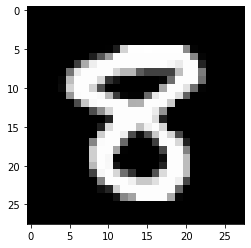

In [11]:
show_random_image(x_train) # rerun to reselect images

In [12]:
test_near_zero(x_train.mean())
test_near_zero(1 - x_train.std())

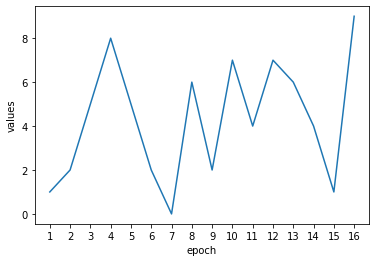

In [13]:
x = [1,2,5,8,5,2,0,6,2,7,4,7,6,4,1,9]
plot_by_epoch(x, 'values')